# MODEL FRUIT METABOLISM (non FVA version)

### Import model

In [1]:
from cobra import io, flux_analysis, util
from cobra.core import Metabolite, Reaction
import numpy as np
from studyFunctions import *
%matplotlib inline

In [2]:
cobra_model2 = io.sbml.create_cobra_model_from_sbml_file("Models/ConstrainedFruitModel.xml")
if "cplex" in util.solvers.keys():
    cobra_model2.solver = "cplex"
else:
    cobra_model2.solver = "glpk"

List2edit = list()
for met in cobra_model2.metabolites:
    if met.id.endswith("_None"):
        List2edit.append(met)

for met in List2edit:
    met.id = met.id.replace("_None","")

cobra_model2.metabolites._generate_index()

weightings = dict()
for rxn in cobra_model2.reactions:
    weightings[rxn.id]=1

for k in ['ILE', '4_AMINO_BUTYRATE', 'GLN', 'GLC', 'GLY', 'CIT', 'GLT', 'FUM', 'SER', 'LYS', 'PRO', 'L_ASPARTATE',
          'ASN', 'L_ALPHA_ALANINE', 'VAL', 'STARCH', 'THR', 'SUCROSE', 'FRU', 'TRP', 'PHE', 'MET', 'MAL', 'TYR']:
    for i in range(1,10):
        if k != "STARCH":
            weightings[k+"_signal"+str(i)]=0

solution2 = pfba_Weighted(cobra_model2,weightings)

### Numbers of osmoles vs biomass

In [3]:
#Day time points of interest
DPA = list(np.linspace(8,59,11))
for i in range(0,len(DPA)):
    DPA[i]=round(DPA[i],1)

xlist = list()
ylist = list()
ylist2= list()
ylist3= list()
ylist4= list()
ylist5= list()
for i in range(1,10):
    xlist.append(i)
    ylist.append(celluloseLevels(DPA[i],Ncells = 25*(10**6)) * 180.16)
    ylist2.append(phospholipidLevels(DPA[i],Ncells = 25*(10**6),scaling_factor=100.0/8.512820512820287)*689.978637415773)
    ylist3.append(estimateProteinContent(DPA[i],ProtConc=21458.1747597,Ncell = 25*(10**6)) * 461.181100469)
    temp = 0
    temp2=0
    if i == 1:
        TEMP=0
        for rxn in cobra_model2.reactions.query("Initial"):
            for met in rxn.products:
                if not("CC" in met.id or "VC" in met.id or "CO" in met.id or "VO" in met.id or "PROTON" in met.id):
                    TEMP=TEMP+(met.formula_weight*solution2.fluxes.get(rxn.id))
    for rxn in cobra_model2.reactions.query("Transfer"+str(i)+str(i+1)):
        for met in rxn.reactants:
            if not("CC" in met.id or "VC" in met.id or "CO" in met.id or "VO" in met.id or "PROTON" in met.id):
                temp=temp+(met.formula_weight*solution2.fluxes.get(rxn.id))
                
    ylist4.append(temp)
    TEMP=temp
    if i == 1:
        TEMP2 = solution2.fluxes.get("Initial_STARCH_tx")*cobra_model2.metabolites.STARCH_p1.formula_weight
    temp2 = solution2.fluxes.get("STARCH_p_Transfer"+str(i)+str(i+1))*cobra_model2.metabolites.STARCH_p1.formula_weight
    ylist5.append(temp2)
    TEMP2 = temp2
    

ylist6=list()
for i in range(0,len(ylist5)):
    ylist6.append(ylist[i]+ylist2[i]+ylist3[i]+ylist4[i]+ylist5[i])


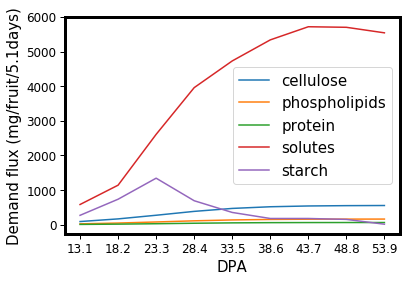

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

plt.xlabel("DPA")
plt.xticks(xlist,DPA[1:],fontsize=12)
plt.ylabel("Demand flux (mg/fruit/5.1days)")
plt.yticks(fontsize=12)
plt.plot(xlist,ylist,label="cellulose")
plt.plot(xlist,ylist2,label="phospholipids")
plt.plot(xlist,ylist3,label="protein")
plt.plot(xlist,ylist4,label="solutes")
plt.plot(xlist,ylist5,label="starch")
plt.legend(loc="best")

In [5]:
import pandas as pd
df3 = pd.DataFrame(data={"Phase":xlist,"cellulose":ylist,"phospholipids":ylist2,"protein":ylist3,"starch":ylist5,"solutes":ylist4,"total":ylist6})
df3

,Phase,cellulose,phospholipids,protein,solutes,starch,total
0,1,94.226241,27.939999,11.268824,585.881044,273.600069,992.916177
1,2,170.620394,50.634839,19.311164,1143.525478,738.311120,2122.402995
2,3,275.767896,81.881697,31.300670,2610.090999,1345.449744,4344.491006
3,4,387.488764,115.088436,45.143915,3958.055834,694.652719,5200.429668
4,5,472.679631,140.412413,56.103907,4728.607574,356.833471,5754.636996
5,6,520.922931,154.754066,62.174225,5336.167198,182.552937,6256.571358
6,7,543.440581,161.448221,64.789131,5715.370949,182.552937,6667.601819
7,8,552.962310,164.278916,65.748686,5699.335176,156.101111,6638.426199
8,9,556.816243,165.424648,66.057177,5539.750335,17.280061,6345.328463


In [6]:
y2list = list()
y2list2 = list()
y2list3 = list()
y2list4 = list()
y2list5 = list()
y2list6 = list()
for i in range(0,len(ylist)):
    y2list.append(round(100*ylist[i]/ylist6[i],2))
    y2list2.append(round(100*ylist2[i]/ylist6[i],2))
    y2list3.append(round(100*ylist3[i]/ylist6[i],2))
    y2list4.append(round(100*ylist4[i]/ylist6[i],2))
    y2list5.append(round(100*ylist5[i]/ylist6[i],2))

df4 = pd.DataFrame(data={"Phase":xlist,"cellulose":y2list,"phospholipids":y2list2,"protein":y2list3,"starch":y2list5,"solutes":y2list4,"total":ylist6})
df4

,Phase,cellulose,phospholipids,protein,solutes,starch,total
0,1,9.49,2.81,1.13,59.01,27.56,992.916177
1,2,8.04,2.39,0.91,53.88,34.79,2122.402995
2,3,6.35,1.88,0.72,60.08,30.97,4344.491006
3,4,7.45,2.21,0.87,76.11,13.36,5200.429668
4,5,8.21,2.44,0.97,82.17,6.20,5754.636996
5,6,8.33,2.47,0.99,85.29,2.92,6256.571358
6,7,8.15,2.42,0.97,85.72,2.74,6667.601819
7,8,8.33,2.47,0.99,85.85,2.35,6638.426199
8,9,8.78,2.61,1.04,87.30,0.27,6345.328463
